$$\textbf{ Chapter 8: 9-City Traveling Salesman Problem}$$

##### The TSP problem is formulated as follows: A traveling salesman is a person that goes from city to city to sell merchandise. Given a list of cities and the distances between each pair of cities, what is the shortest possible route that enables visiting each city exactly once and then returns to the city of origin?}

In [166]:
## Libraries & visualization tools for us to use.

import networkx as nx
import pylab
import matplotlib.pyplot as plt
from matplotlib.pyplot import pause
import sys
from bokeh.sampledata import us_states
from bokeh.plotting import *
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.io import output_notebook
from bokeh.palettes import Spectral4
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
output_notebook()
%matplotlib inline

import argparse
import re

Loading BokehJS ...

In [167]:
# Number of cities in our problem
N = 9

# Function to compute index in Q for variable x_(a,b)
def x(a, b):
    return (a)*N+(b)

In [168]:
# Gamma = A
A = 6500
B = 1
chainstrength = 3000
# Number of runs
numruns = 100

In [169]:
us_states = us_states.data.copy()

del us_states["HI"]
del us_states["AK"]

# separate latitude and longitude points for the borders
#   of the states.
state_xs = [us_states[code]["lons"] for code in us_states]
state_ys = [us_states[code]["lats"] for code in us_states]

with open('data_9cities.txt', "r") as myfile:
    city_text = myfile.readlines()
    myfile.close()
cities = [',']*N
states = [',']*N
lats=[]
longs=[]
for i in city_text:
    index, state, city,lat,lon = i.split(',')
    cities[int(index)] = city.rstrip()
    states[int(index)] = state
    lats.append(float(lat))
    longs.append(float(lon))

# init figure
p = figure(title="Find shortest route that visits each city", 
           toolbar_location="left", plot_width=550, plot_height=350)

# Draw state lines
p.patches(state_xs, state_ys, fill_alpha=0.0,
    line_color='blue', line_width=1.5)

# The scatter markers
p.circle(longs, lats, size=10, color='red', alpha=1)
show(p)

##### Reading the Data

In [170]:
# Input file containing inter-city distances
fn = "data_distance9.txt"

# check that the user has provided input file
try:
  with open(fn, "r") as myfile:
    distance_text = myfile.readlines()
    myfile.close()
except IOError:
  print("Input distance file missing")
  exit(1)

In [171]:
# Initialize matrix of correct size with all 0's
D = [[0 for z in range(N)] for y in range(N)]

# Read in distance values and enter in matrix
for i in distance_text:
  if re.search("^between", i):
    m = re.search("^between_(\d+)_(\d+) = (\d+)", i)
    citya = int(m.group(1))
    cityb = int(m.group(2))
    D[citya][cityb] = D[cityb][citya] = int(m.group(3))

In [172]:
Q = {}
for i in range(N*N):
    for j in range(N*N):
        Q.update({(i,j): 0})

In [173]:
for v in range(N):
    for j in range(N):
        Q[(x(v,j), x(v,j))] += -1*A
        for k in range(j+1, N):
            Q[(x(v,j), x(v,k))] += 2*A

In [174]:
for j in range(N):
    for v in range(N):
        Q[(x(v,j), x(v,j))] += -1*A
        for w in range(v+1,N):
            Q[(x(v,j), x(w,j))] += 2*A

In [175]:
for u in range(N):
    for v in range(N):
        if u!=v:
            for j in range(N):
                Q[(x(u,j), x(v,(j+1)%N))] += B*D[u][v]

In [176]:
from dwave_qbsolv import QBSolv
resp = QBSolv().sample_qubo(Q)

Post-Processing



In [177]:
# First solution is the lowest energy solution found
sample = next(iter(resp))

# Display energy for best solution found
print('Energy: ', next(iter(resp.data())).energy)

# Print route for solution found
route = [-1]*N
for node in sample:
    if sample[node]>0:
        j = node%N
        v = (node-j)/N
        if route[j]!=-1:
            print('Stop '+str(i)+' used more than once.\n')
        route[j] = int(v)
        
# Compute and display total mileage
mileage = 0
for i in range(N):
    mileage+=D[route[i]][route[(i+1)%N]]
print('Mileage: ', mileage)
        
print('\nRoute:\n')
for i in range(N):
    if route[i]!=-1:
        print(str(i) + ':  ' +cities[route[i]]+ ',' + states[route[i]] + '\n')  
    else:
        print(str(i) + ':  No city assigned.\n')

Energy:  -114297.0
Mileage:  2703

Route:

0:  Springfield,Illinois

1:  Denver,Colorado

2:  Trenton,New Jersey

3:  Dover,Delaware

4:  Hartford,Connecticut

5:  Boston,Massachusetts

6:  Concord,New Hampshire

7:  Lansing,Michigan

8:  Indianapolis,Indiana



Verification of our Result


In [178]:
alert = 0

if sum(route)!=N*(N-1)/2:
    print('Route invalid.\n')

for i in range(N):
    if route[i]==-1:
        print('Stop '+str(i)+' has no city assigned.')
        
if alert==0:
    print("Route valid.")

Route valid.


##### Visualization
The code last block visualizes the route found.  

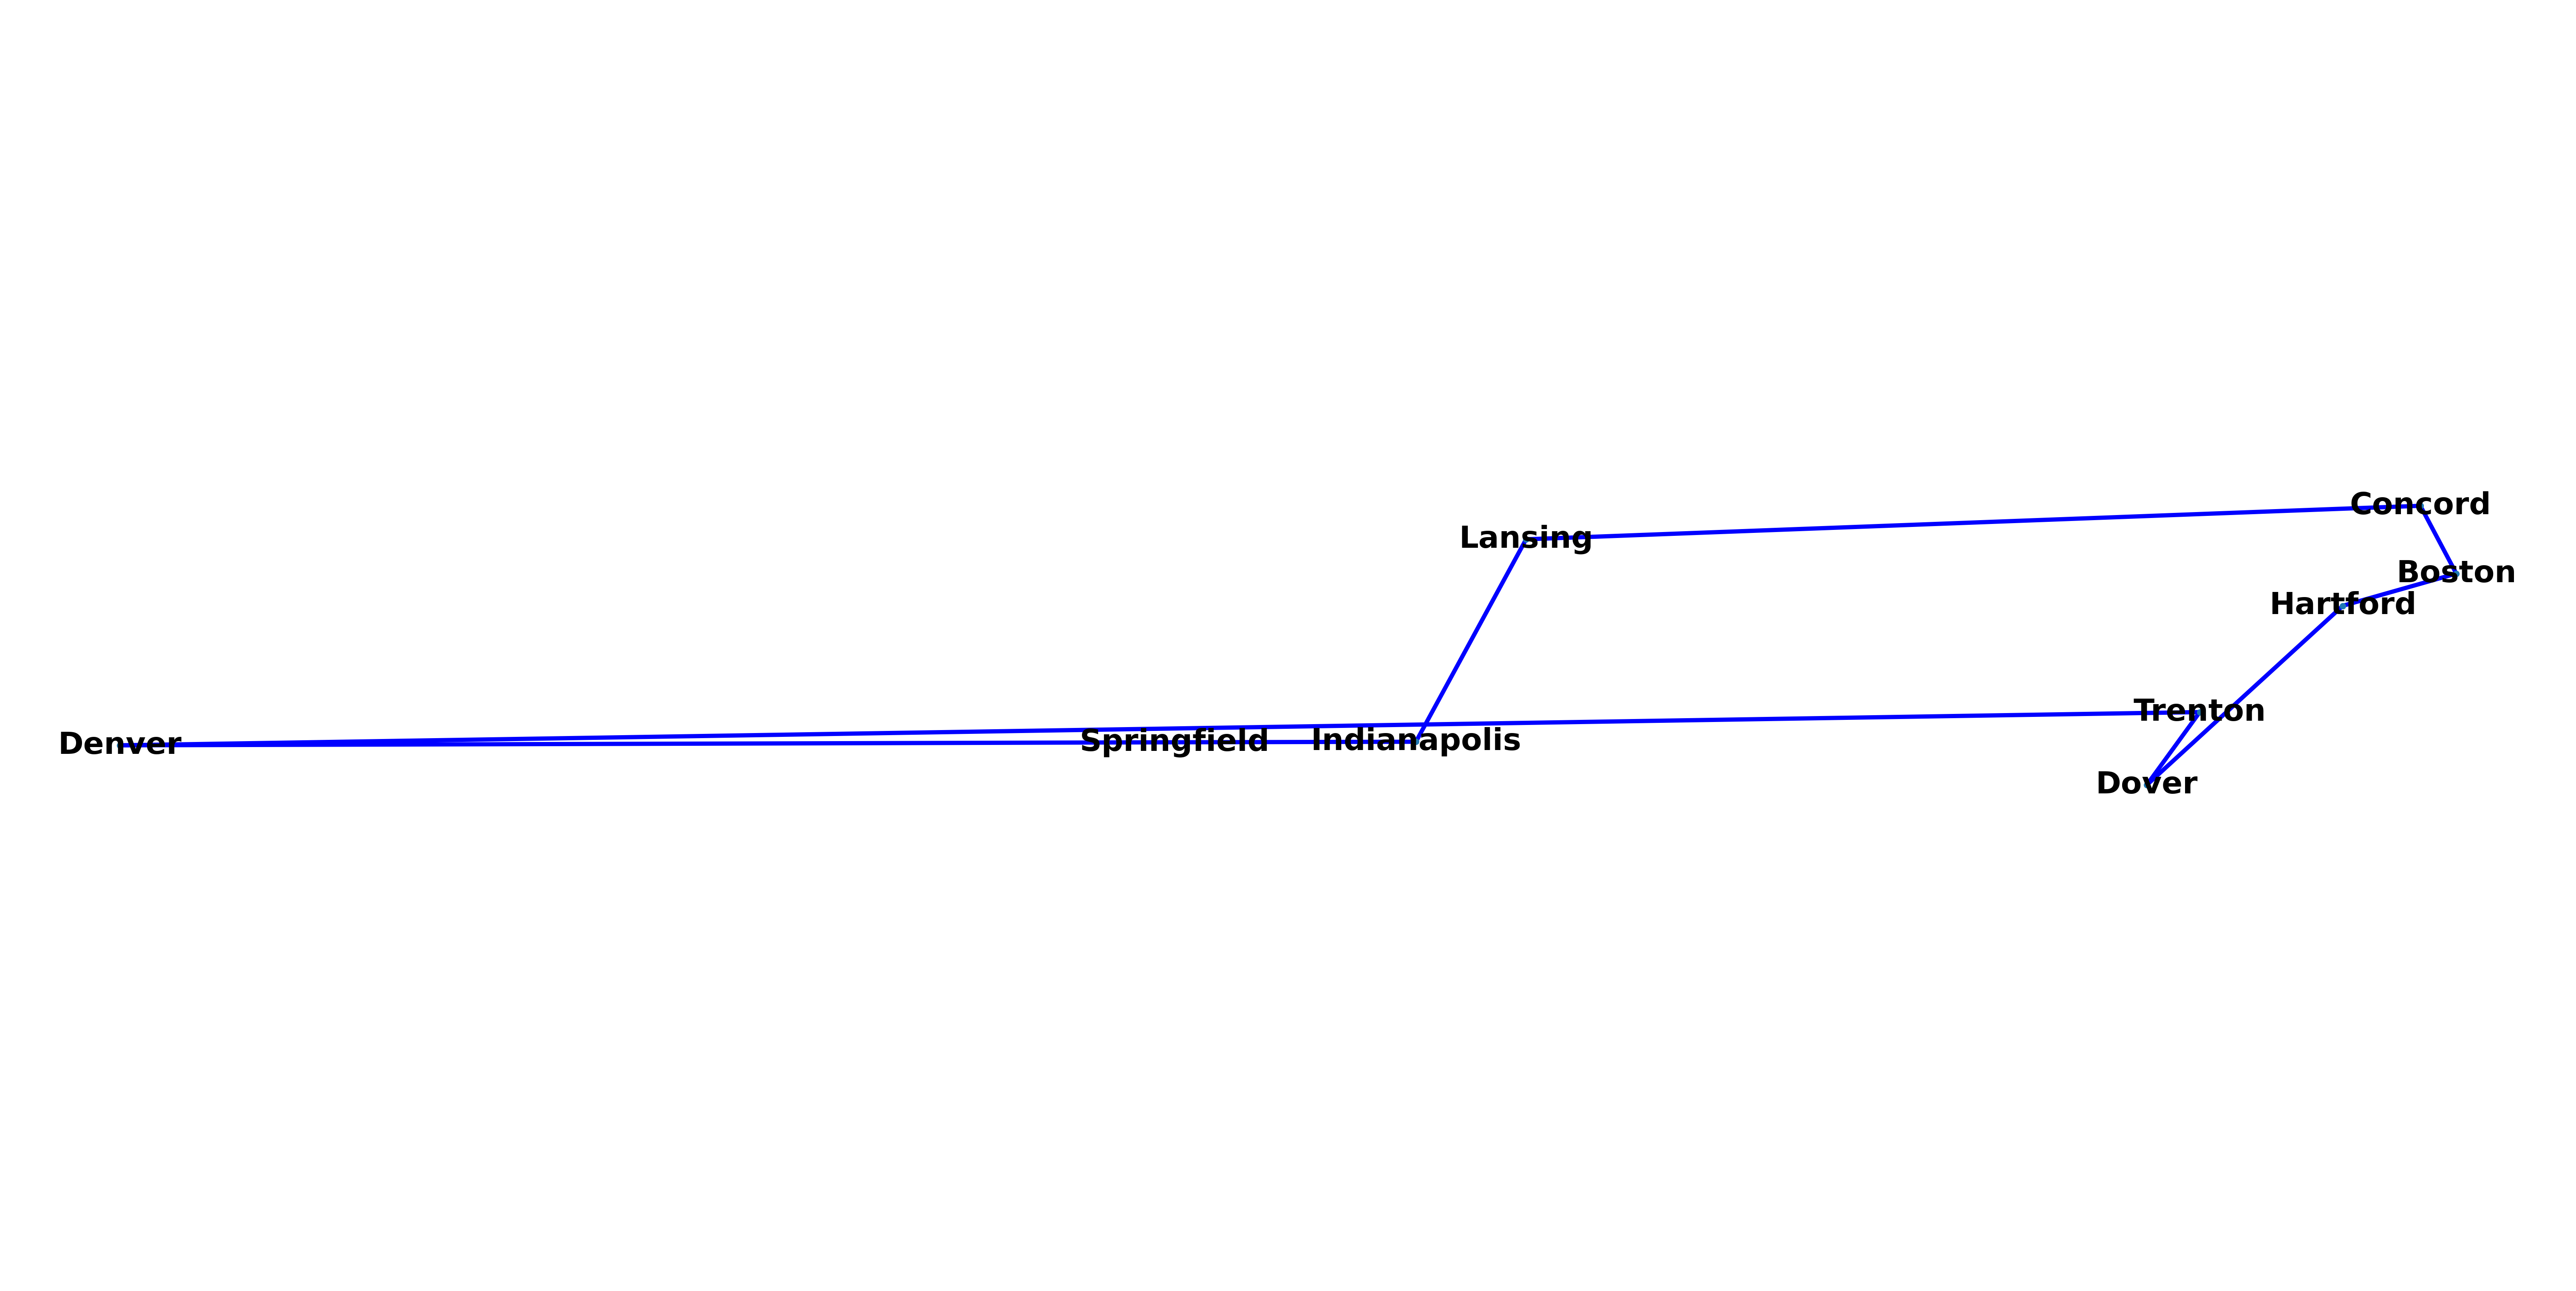

In [179]:
Path = nx.Graph()

coord={}
coord[route[0]]=(longs[route[0]],lats[route[0]])
Path.add_node(cities[route[0]],pos=coord[route[0]],label=cities[route[0]])

for i in range(N-1):
    e=(cities[route[i]],cities[route[i+1]])
    Path.add_edge(*e)
    coord[route[i+1]]=(longs[route[i+1]],lats[route[i+1]])
    Path.add_node(cities[route[i+1]],pos=coord[route[i+1]],label=cities[route[i+1]])

e=(cities[route[N-1]],cities[route[0]])
Path.add_edge(*e)
    
fig, ax = plt.subplots(figsize=(120,60))
margin=0.15
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')
nx.draw(Path, nx.get_node_attributes(Path, 'pos'), with_labels=True, width=10, edge_color='b', node_size=200,font_size=72,font_weight='bold', ax=ax)
plt.show() 